# Combined SINGLE VIEW


Comparison using ORB similarity combined with Cosine similarity for the VeRi dataset.

In [9]:
# Notebook variables
# ---------------------
# should tests be runned?
run_simulations = False

# should the test data be saved?
save_simulation_data = False

# should the stored test data be loaded?
load_simulation_data = True

# imports/packages

In [2]:
# installs opencv if required
# !pip install opencv-python

In [6]:
# import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from importlib import reload

# import the precomputed distance matrix function for AntClust

if run_simulations:
    import math
    import os
    import random as rng
    import sys
    import time
    from concurrent.futures import ProcessPoolExecutor
    # make AntClus dir known
    import sys
    sys.path.append("../AntClust")
    import cv2 as cv
    from AntClust import AntClust
    import distance_classes
    reload(distance_classes)# import the rule set
    from distance_classes import (
        opencv_image_flann_similarity,
        opencv_image_orb_similarity,
        opencv_orb_similarity,
        precomputed_similarity_matrix,
        image_cosine_similarity
    )
    from rules import labroche_rules
    from sklearn.metrics import adjusted_rand_score, rand_score

# data functions

In [ ]:
def data_cluster_images_static(
    data_folder, num_clusters, num_images_per_cluster, seed=3
):
    """
    Will generate num_clusters clusters with num_images_per_cluster pictures each
    """
    # get the cars
    car_dir_names = sorted(os.listdir(data_folder), key=lambda x: x)

    # remove ipycheckpoint
    if car_dir_names[0] == ".ipynb_checkpoints":
        car_dir_names = car_dir_names[1::]

    # make a random shuffle of the cars/folders to take
    rng.seed(seed)
    cars_to_take = rng.sample(car_dir_names, len(car_dir_names))
    cars_to_take = cars_to_take[0:num_clusters:]

    # make the cluster data and the labels
    # generate num_clusters and add num_images_per_cluster to each cluster
    cluster_image: list = []
    cluster_labels: list = []

    label_counter = 0
    for car_folder in cars_to_take:
        # take images and shuffle them
        imgs = sorted(os.listdir(data_folder + "/" + car_folder), key=lambda x: x)
        imgs = rng.sample(imgs, len(imgs))

        # make data and labels
        # add the respectiv car folder as path
        cluster_image = cluster_image + [
            str(car_folder) + "/" + image for image in imgs[0:num_images_per_cluster:]
        ]
        cluster_labels = cluster_labels + [label_counter] * num_images_per_cluster
        label_counter += 1

    # read the images as opencv images from disk
    image_data = []
    for image_file in cluster_image:
        image_data.append(
            [cv.imread(data_folder + "/" + image_file, cv.IMREAD_GRAYSCALE)]
        )

    return cluster_image, image_data, cluster_labels


def data_cluster_images_dynamic(
    data_folder,
    num_clusters,
    num_images_per_cluster_min,
    num_images_per_cluster_max,
    seed=3,
):
    """
    Will generate num_clusters clusters where a random ammount of images in
    the range [num_images_per_cluster_min, num_images_per_cluster_max]
    """
    # get the cars
    car_dir_names = sorted(os.listdir(data_folder), key=lambda x: x)

    # remove ipycheckpoint
    if car_dir_names[0] == ".ipynb_checkpoints":
        car_dir_names = car_dir_names[1::]

    # make a random shuffle of the cars/folders to take
    rng.seed(seed)
    cars_to_take = rng.sample(car_dir_names, len(car_dir_names))
    cars_to_take = cars_to_take[0:num_clusters:]

    # make the cluster data and the labels
    # generate num_clusters and add a random ammount of images (in min, max range) to each cluster
    cluster_image: list = []
    cluster_labels: list = []

    label_counter = 0
    for car_folder in cars_to_take:
        # take images and shuffle them
        imgs = sorted(os.listdir(data_folder + "/" + car_folder), key=lambda x: x)
        imgs = rng.sample(imgs, len(imgs))

        # make data and labels
        num_images = rng.randint(num_images_per_cluster_min, num_images_per_cluster_max)
        # add the respectiv car folder as path
        cluster_image = cluster_image + [
            str(car_folder) + "/" + image for image in imgs[0:num_images:]
        ]
        cluster_labels = cluster_labels + [label_counter] * num_images
        label_counter += 1

    # read the images as opencv images from disk
    # and put them into their own array as data tuple
    image_data = []
    for image_file in cluster_image:
        image_data.append(
            [cv.imread(data_folder + "/" + image_file, cv.IMREAD_GRAYSCALE)]
        )

    return cluster_image, image_data, cluster_labels

def compute_orb_image_features(images, image_resize_size):
    # Initiate ORB detector for feature extraction
    orb = cv.ORB_create()
    descriptors = []
    # compute key points and descriptors
    for image in images:
        img = image[0]
        img = cv.resize(img, image_resize_size)
        kp, des = orb.detectAndCompute(img, None)
        descriptors.append([des])

    return descriptors

In [ ]:
# Global Variables
fitness_ari_static = []
fitness_ri_static = []
fitness_ari_dynamic = []
fitness_ri_dynamic = []

# test functions

In [ ]:
# single process test
def run_cluster_test_static(
    clusters_min,
    clusters_max,
    values_min,
    values_max,
    data_folder,
    ant_clust_params={"alpha": 150, "betta": 0.5, "shrink": 0.2, "removal": 0.3},
    seed=3,
    image_resize_size=(150, 172),
):
    """
    Will run the static cluster tests where it will test from
    clusters_min to clusters_max
    each test contains
    values_min to values_max
    data samples.
    """

    # run all tests
    for num_clusters in range(clusters_min, clusters_max + 1):
        c_fitness_ari = []
        c_fitness_ri = []
        print(f"testing values for {num_clusters} clusters")
        for values_per_cluster in range(values_min, values_max + 1):
            # ------------------
            # data
            # ------------------
            # data_cluster_images_static(data_folder, num_clusters, num_images_per_cluster, seed)
            image_names, data_img, labels = data_cluster_images_static(
                data_folder, num_clusters, values_per_cluster, seed
            )
            image_resize_size=(150, 172)
            images = compute_orb_image_features(data_img, image_resize_size)
            data_img = np.array(images, dtype=list)
            labels = np.array(labels)

            # distance matrix for sklearn
            orb_sim = opencv_orb_similarity()
            distance_matrix = []
            for i in range(len(data_img)):
                t_l = []
                for n in range(len(data_img)):
                    t_l.append(orb_sim.similarity(data_img[i][0], data_img[n][0]))
                distance_matrix.append(t_l)

            # sklearn needs it in the way that 0 means a==b
            # ant clust needs it in the way 1 means a==b
            distance_matrix = 1 - np.array(distance_matrix)
            # AntClust needs every data tuple as an array.
            # e.g. [1,2,3] needs to be [[1],[2],[3]]
            data = [[i, distance_matrix[i]] for i in range(len(image_names))]

            # ------------------
            # run clustering
            # ------------------
            # similarity function
            f_sim = [image_cosine_similarity("single_view/data/",image_names),
                    precomputed_similarity_matrix()]

            # rules
            rules = labroche_rules()

            # AntClust
            ant_clust_params = {
                "alpha": 500,
                "betta": 0.9,
                "shrink": 0.2,
                "removal": 0.3,
            }
            ant_clust = AntClust(
                f_sim,
                rules,
                alpha_ant_meeting_iterations=ant_clust_params["alpha"],
                betta_template_init_meetings=ant_clust_params["betta"],
                nest_shrink_prop=ant_clust_params["shrink"],
                nest_removal_prop=ant_clust_params["removal"],
                print_status=False,
            )

            # find clusters
            ant_clust.fit(data)

            # get the clustering result
            clusters_found = ant_clust.get_clusters()
            # print(clusters_found)

            # ------------------
            # calc error
            # ------------------
            # use ari as score
            try:
                ari = adjusted_rand_score(labels[:min(len(labels),len(clusters_found))], clusters_found[:min(len(labels),len(clusters_found))])
                c_fitness_ari.append(ari)

                # use ri as score
                ri = rand_score(labels[:min(len(labels),len(clusters_found))], clusters_found[:min(len(labels),len(clusters_found))])
                c_fitness_ri.append(ri)
            except:
                pass

        # append fitness for that cluster ammount
        fitness_ari_static.append(c_fitness_ari)
        fitness_ri_static.append(c_fitness_ri)



# plot functions

In [7]:
def plot_3d(X, Y, Z, score_method):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    fig.dpi = 300
    # fig.figsize = (160, 8)
    # Plot the surface.
    # surf = ax.plot_surface(X, Y, Z, cmap=cm.RdBu, linewidth=0, antialiased=True)
    surf = ax.plot_surface(X, Y, Z, cmap=cm.PiYG, linewidth=0, antialiased=True)

    # Customize the z axis.
    ax.set_zlim(-0.0, 1.0)
    ax.zaxis.set_major_locator(LinearLocator(10))
    # A StrMethodFormatter is used automatically
    ax.zaxis.set_major_formatter("{x:.02f}")

    # set axis labels
    plt.xlabel("clusters")
    plt.ylabel("datapoints")
    # plt.xticks(X[0])
    plt.title(score_method)

    # ax.text(5, 0, 1, "5", color='red')

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)

    # save figure
    plt.savefig(f"{score_method}.pdf", bbox_inches="tight")

    plt.show()

# performance tests
# -----------------------


# static cluster performance

In [ ]:
# ORIGINAL VALUES
clusters_min_static = 2
clusters_max_static = 30
values_min_static = 3
values_max_static = 18
fitness_ari_static = []
fitness_ri_static = []
data_folder = "single_view/data"
seed = 9
ant_clust_params = {"alpha": 500, "betta": 0.9, "shrink": 0.2, "removal": 0.3}

if run_simulations:
    start_time = time.time()
    run_cluster_test_static(
        clusters_min_static,
        clusters_max_static,
        values_min_static,
        values_max_static,
        data_folder,
        ant_clust_params=ant_clust_params,
        seed=seed,
        image_resize_size=(150, 172),
    )
    print(f"test took {time.time() - start_time} s")

In [ ]:
fitness_static_ari = fitness_ari_static
fitness_static_ri = fitness_ri_static
print(len(fitness_static_ari))
print(fitness_static_ri)

29
[[1.0, 1.0, 0.9111111111111111, 1.0, 0.8681318681318682, 0.8166666666666667, 0.8823529411764706, 0.7631578947368421, 0.7922077922077922, 0.7246376811594203, 0.7661538461538462, 0.7513227513227513, 0.7609195402298851, 0.7318548387096774, 0.7254901960784313, 0.7333333333333333], [1.0, 1.0, 0.9428571428571428, 0.9477124183006536, 0.8952380952380953, 0.8478260869565217, 0.8746438746438746, 0.8758620689655172, 0.8977272727272727, 0.9063492063492063, 0.8380566801619433, 0.8315911730545877, 0.8323232323232324, 0.8333333333333334, 0.8541176470588235, 0.8378756114605171], [1.0, 0.9666666666666667, 0.968421052631579, 0.9420289855072463, 0.8862433862433863, 0.9314516129032258, 0.8984126984126984, 0.9358974358974359, 0.9016913319238901, 0.8945035460992907, 0.9125188536953243, 0.8896103896103896, 0.8847457627118644, 0.9151785714285714, 0.8867427568042142, 0.9154929577464789], [1.0, 0.9789473684210527, 0.93, 0.9448275862068966, 0.9243697478991597, 0.9333333333333333, 0.9090909090909091, 0.9240816

# dynamic performance

# save and load simulation data


In [10]:
# fitness_dynamic_ari, fitness_dynamic_ri
# fitness_static_ari, fitness_static_ri

# save simulation results
if save_simulation_data:
    with open("fitness_static_ari_single_view_combined.npy", "wb") as f:
        np.save(f, np.array(fitness_static_ari))

    with open("fitness_static_ri_single_view_combined.npy", "wb") as f:
        np.save(f, np.array(fitness_static_ri))


# load simulation results
if load_simulation_data:
    with open("fitness_static_ari_single_view_combined.npy", "rb") as f:
        fitness_static_ari = np.load(f)

    with open("fitness_static_ri_single_view_combined.npy", "rb") as f:
        fitness_static_ri = np.load(f)

EOFError: No data left in file

# make plots from loaded simulation data


# 2D plot of specific data point

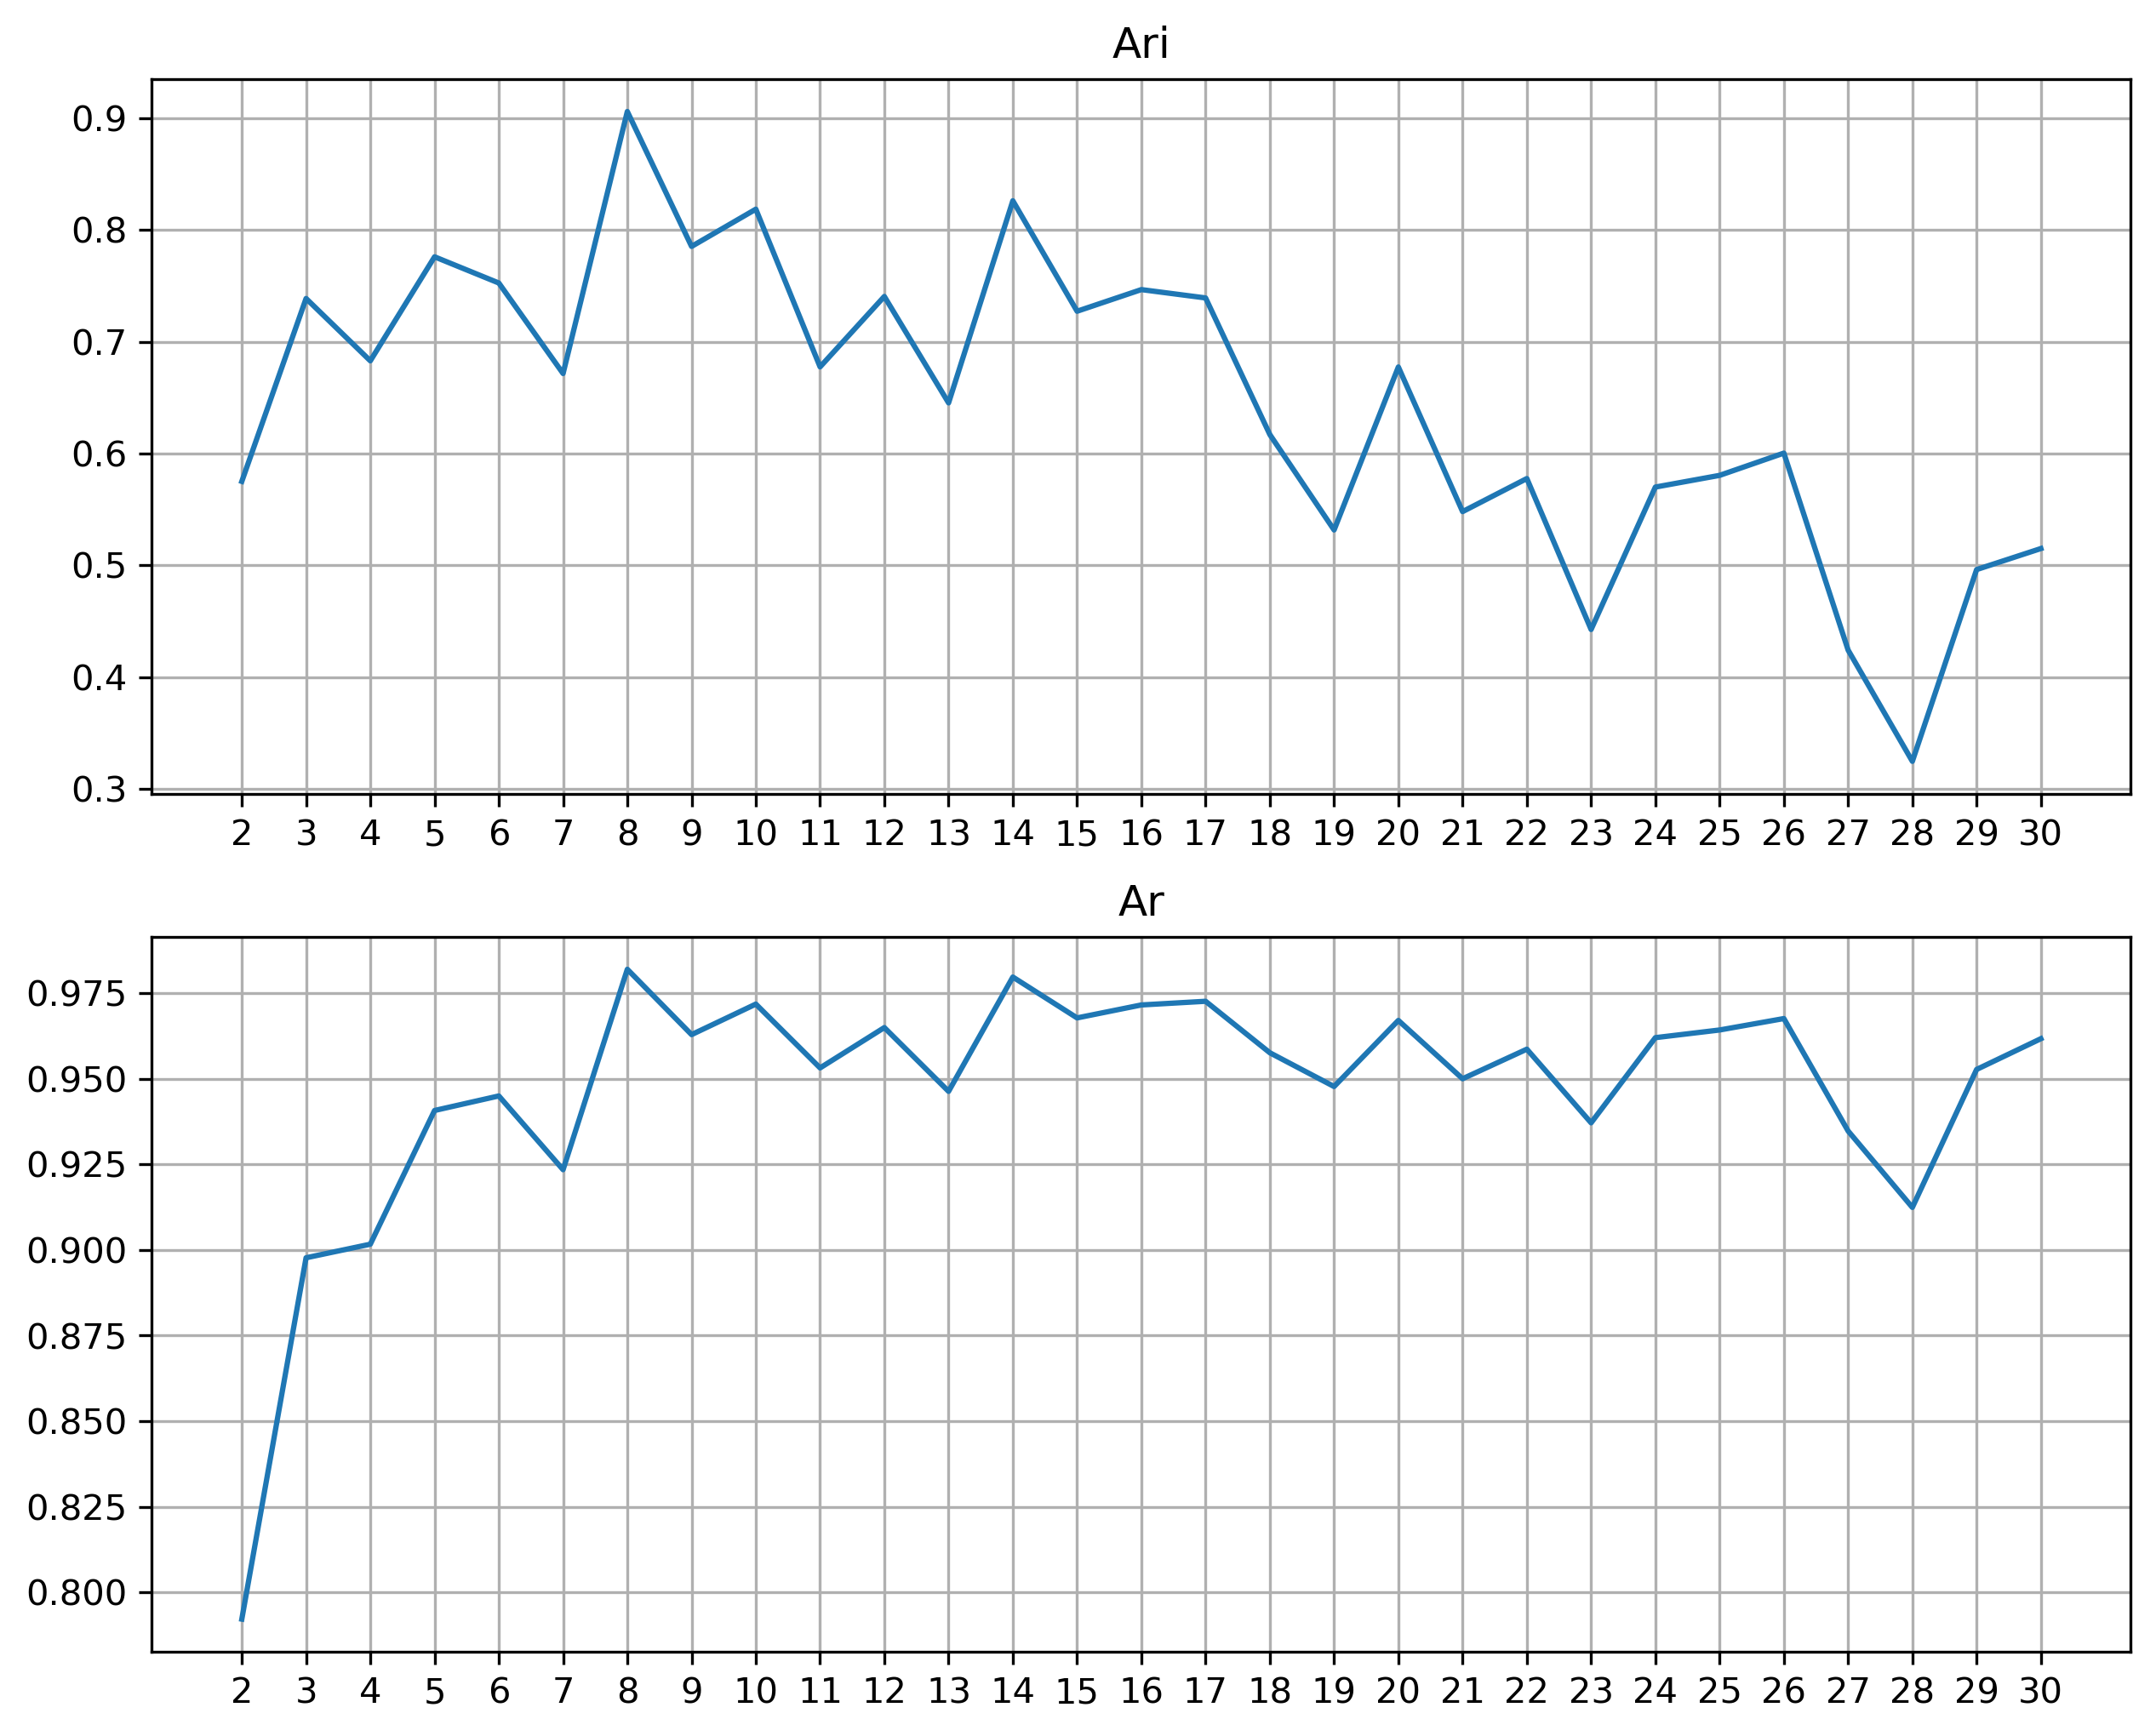

In [ ]:
# ari
data_point = int(len(fitness_static_ari[0]) / 2)
test_data_fixed_points_ari = []
for i in range(0, (clusters_max_static - clusters_min_static) + 1):
    test_data_fixed_points_ari.append(fitness_static_ari[i][data_point])


data_point = int(len(fitness_static_ri[0]) / 2)
test_data_fixed_points_ar = []
for i in range(0, (clusters_max_static - clusters_min_static) + 1):
    test_data_fixed_points_ar.append(fitness_static_ri[i][data_point])

X = np.arange(clusters_min_static, clusters_max_static + 1, 1)


plt.figure(figsize=(10, 8), dpi=300)
# plt.subplot(211)
plt.title("Cosine + ORB similarity (single view images)")
plt.xlabel("Number of cluster")
plt.xlabel("Ari")
plt.plot(X, test_data_fixed_points_ari)
plt.grid()
plt.xticks(X)

# plt.subplot(212)
# plt.title("Ar")
# plt.plot(X, test_data_fixed_points_ar)
# plt.grid()
# plt.xticks(X)

plt.show()

# Visualization of clusters

In [ ]:
def run_antclust(num_cluster,min_imgs,max_imgs):
    image_names, data_img, labels = data_cluster_images_dynamic(
                    "single_view/data",
                    num_cluster,
                    min_imgs,
                    max_imgs,
                    seed=rng.randint(0, sys.maxsize),
                )
    image_resize_size=(150, 172)
    images = compute_orb_image_features(data_img, image_resize_size)
    data_img = np.array(images, dtype=list)
    labels = np.array(labels)

    # distance matrix for sklearn
    orb_sim = opencv_orb_similarity()
    distance_matrix = []
    for i in range(len(data_img)):
        t_l = []
        for n in range(len(data_img)):
            t_l.append(orb_sim.similarity(data_img[i][0], data_img[n][0]))
        distance_matrix.append(t_l)

    # sklearn needs it in the way that 0 means a==b
    # ant clust needs it in the way 1 means a==b
    distance_matrix = 1 - np.array(distance_matrix)
    # AntClust needs every data tuple as an array.
    # e.g. [1,2,3] needs to be [[1],[2],[3]]
    data = [[i, distance_matrix[i]] for i in range(len(image_names))]

    # ------------------
    # run clustering
    # ------------------
    # similarity function
    f_sim = [image_cosine_similarity("single_view/data/",image_names),
             precomputed_similarity_matrix()]

    
    # rules
    rules = labroche_rules()

    # AntClust
    ant_clust = AntClust(
        f_sim,
        rules,
        alpha_ant_meeting_iterations=ant_clust_params["alpha"],
        betta_template_init_meetings=ant_clust_params["betta"],
        nest_shrink_prop=ant_clust_params["shrink"],
        nest_removal_prop=ant_clust_params["removal"],
        print_status=False,
    )

    # find clusters
    ant_clust.fit(data)

    # get the clustering result
    clusters_found = ant_clust.get_clusters()
    imgs_cluster = {}
    # print(f"Number of images: {len(image_names)}, number of clusters found: {len(np.unique(np.array(clusters_found)))}")
    for i, img in enumerate(image_names):
        img_path = "single_view/data/"+img
        if clusters_found[i] in imgs_cluster:
            imgs_cluster[clusters_found[i]].append(img_path)
        else:
            imgs_cluster[clusters_found[i]] = [img_path]
    return imgs_cluster, labels, clusters_found

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

def display_images(image_paths, cluster_id):
    num_images = len(image_paths)
    num_cols = min(num_images, 3)  # Maximum of 3 columns for better visualization
    num_rows = (num_images - 1) // num_cols + 1
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))
    
    for i, path in enumerate(image_paths):
        row = i // num_cols
        col = i % num_cols
        
        img = mpimg.imread(path)
        img = img[::2, ::2]  # Resizing the image to half its size
        
        if num_rows == 1:  # If there's only one row, axes is not a 2D array
            if num_images > 1:
                axes[col].imshow(img)
            else:
                axes.imshow(img)
        else:
            axes[row, col].imshow(img)
    
    # Remove empty subplots
    for i in range(num_images, num_rows * num_cols):
        if num_rows == 1:
            fig.delaxes(axes[i])
        else:
            fig.delaxes(axes.flatten()[i])
    
    fig.suptitle(f'Cluster {cluster_id}', fontsize=16)  # Add a single title for the entire graph
    plt.tight_layout()
    plt.show()


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Ajusted Rand Index: 0.0


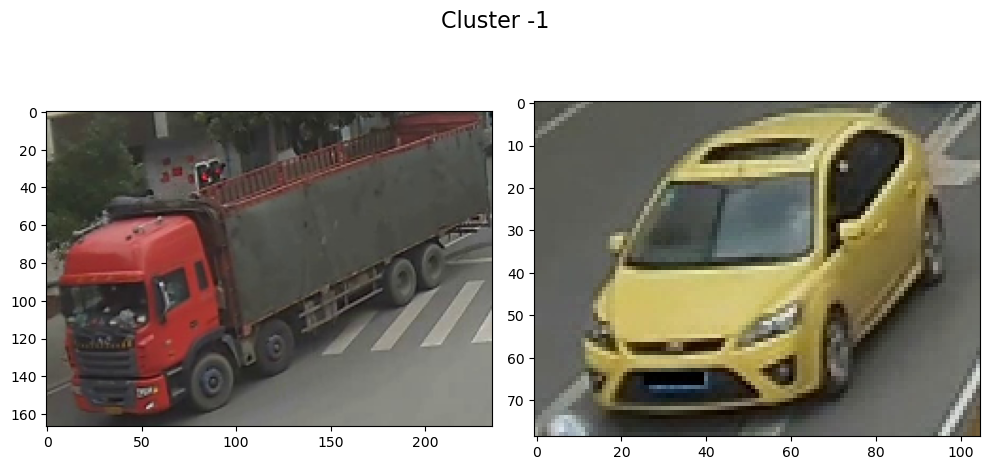

In [ ]:
clusters_images, real_label, antclust_label = run_antclust(2,1,2)
ari = adjusted_rand_score(real_label,antclust_label)
print(f"Ajusted Rand Index: {ari}")
for key in clusters_images:
    display_images(clusters_images[key],key)